## Overview

In this notebook, we load a saved model trained in `example_model_training.ipynb`, and use it to perform predictive 
inference on events of interest from frames from a new video it has not been trained on.

In [20]:
"""Imports."""

from pathlib import Path
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import models, transforms
from tqdm import tqdm

In [2]:
"""Specify which device (CPU or GPU) to use"""

if torch.cuda.is_available():  # if we have a GPU and its available to pytorch, use it
    device = torch.device("cuda")
    print(f"Using GPU device: {torch.cuda.get_device_name(device)}\n")
else:  # else, use cpu
    device = torch.device("cpu")
    print("Using CPU.\n")

Using CPU.



In [7]:
"""Load saved model."""

# Configure model class.
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

dropout_rate = 0.2  # 20% cell removal to help with generalization
n_classes = 2  # 1. posesssion 2. set pieces
model.classifier = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.classifier.in_features, n_classes),
    nn.Sigmoid()  # Use sigmoid for binary multiclass, multilabel classification
)

# Load model.
model_path = Path(r"C:\Users\jai\veo_nu\models\MatchMentor_Liverpool_Loss=0.009_ValLoss=0.180.pth")
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [21]:
"""Pass all frames from video through, get rounded predictions for each frame."""

# TODO: 1. Batch frames when passing into model. 2. Remove generator function - work directly on `cap`

# Create a frame generator function.
def frame_generator(video_path):
    """Yields frames from an mp4 video file."""
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        yield frame
    cap.release()


n_channels, height, width = 3, 224, 224  # dimensions of frames for model
video_path = Path(r"C:\Users\jai\veo_nu\data\NN_Cut_Clip_downsampled.mp4")
frames = frame_generator(str(video_path))
n_frames = 30 * 60 * 5  # 30 fps * 60 seconds * 5 minutes
out = []  # Store predictions: will be n_frames x n_classes

model.eval()
with torch.no_grad():
    pbar = tqdm(enumerate(frames), total=n_frames, desc="Frames predicted")  # tqdm progress bar
    for frame_i, frame in pbar:
        # Preprocess frame.
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # convert to rgb
        frame = transforms.ToTensor()(frame).float()  # convert to tensor
        frame = transforms.Resize((height, width))(frame)  # resize to model input size
        frame = frame.unsqueeze(0)  # add batch dimension
        frame = frame.to(device)
        # Pass frame through model.
        pred = model(frame)
        out.append(pred)
        pbar.set_postfix_str(f"{frame_i=} / {n_frames}")
    print("Done.")

Frames predicted:  80%|████████  | 7234/9000 [11:52<02:54, 10.15it/s, frame_i=7233 / 9000]

Done.


In [ ]:
"""Convert these predictions to text format: ("Possession: True / False", "Set Piece: True / False")."""

out_as_np = torch.cat(out).cpu().numpy()
out_as_np = np.where(out_as_np > 0.5, 1, 0)  # threshold at 0.5 to get binary predictions

out_as_df = pd.DataFrame(out_as_np, columns=["Possession", "Set Piece"])
out_as_df = out_as_df.astype({col: "bool" for col in out_as_df.columns})

In [158]:
display(out_as_df)

,Possession,Set Piece
0,True,False
1,True,False
2,True,False
3,True,False
4,True,False
...,...,...
7229,False,False
7230,False,False
7231,False,False
7232,False,False


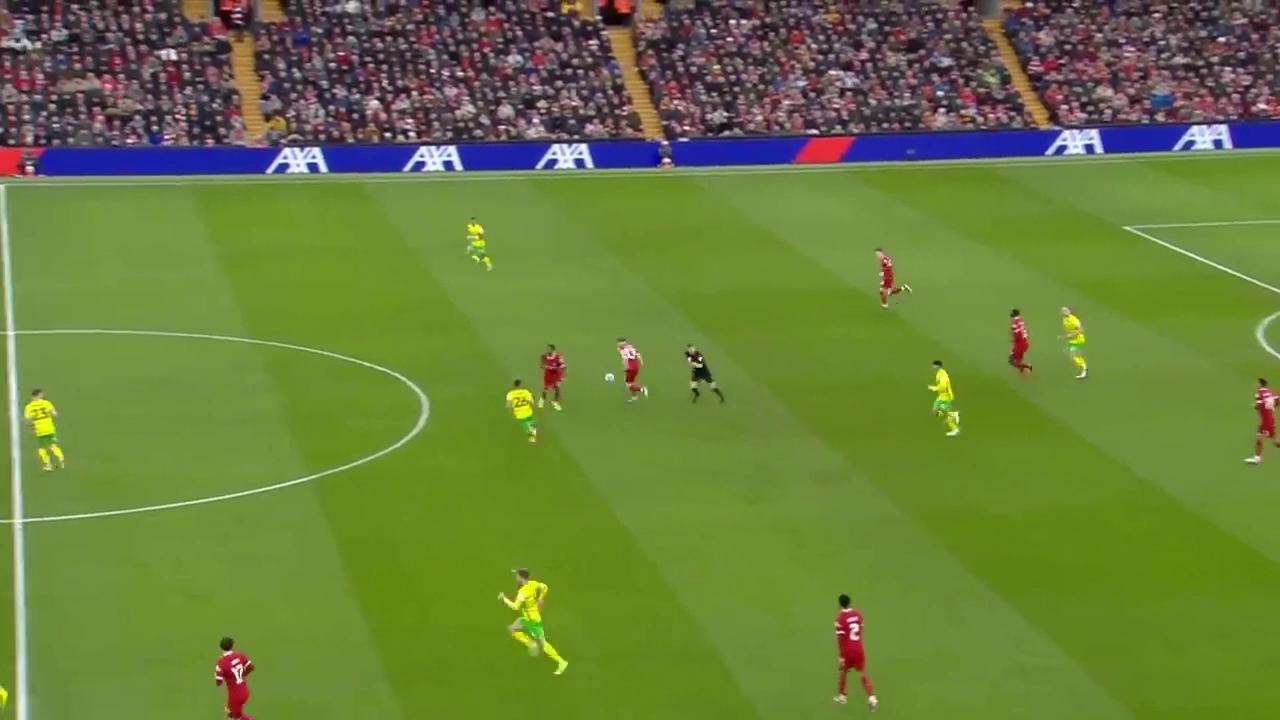

In [159]:
"""Overlay text on video frame-by-frame, save new output video."""

# TODO: add progress bar

in_path = Path(r"C:\Users\jai\veo_nu\data\NN_Cut_Clip.mp4")
out_path = Path(r"C:\Users\jai\veo_nu\data\NN_Cut_Clip_out.mp4")
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps, width, height = 30, 1280, 720
out = cv2.VideoWriter(str(out_path), fourcc, fps, (width, height))
cap = cv2.VideoCapture(str(in_path))

frame_i = 0
while cap.isOpened():
    if frame_i >= len(out_as_df):
        break
    ret, frame = cap.read()
    if not ret:
        break
    text_lines = [f"{col}: {row}" for col, row in out_as_df.iloc[frame_i].items()]
    text = "\n".join(text_lines)
    px_offset = 50  # offset from bottom left corner
    px_vspace = 25  # vertical space between lines
    ft_col = (255, 255, 255)  # font color
    ft_sz_x = 0.75  # font size factor
    ft_wt = 2  # font weight
    for i, line in enumerate(text.split('\n')):
        cv2.putText(frame, line, (px_offset, height - px_offset - (len(text_lines) - i) * px_vspace),
                    cv2.FONT_HERSHEY_SIMPLEX, ft_sz_x, ft_col, ft_wt)
    out.write(frame)
    frame_i += 1

# Display last frame to make sure it worked as expected, and release resources.
display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
cap.release()
out.release()